# Real data analysis

## Package imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import combinations
from stldecompose import decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

## Import data from two customers

In [50]:
data = pd.read_csv('data/test_new.csv',sep='     ')
data.index = data['ga:dateHour']
data.index = pd.to_datetime(data.index, format='%Y%m%d%H')
del data['ga:dateHour']

C:\Users\s124330\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
data_h = pd.read_csv('data/test.csv')
data_h.index = data_h['ga:dateHour']
data_h.index = pd.to_datetime(data_h.index, format='%Y%m%d%H')
del data_h['ga:dateHour']

## Functions used for analysis

In [8]:
def norm_xcorr(a, b):
    ''' Return max correlation and corresponding lag.'''
    npts = len(a)
    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(a - a.mean(), b - b.mean(), mode='full')
    ccor = ccov / (npts * a.std() * b.std())
    
    return ccor.max(), lags[np.argmax(ccor)]

In [9]:
def norm_xcorr_df(data):
    ''' Return two dataframes with cross-correlations and according lags.'''
    
    corr_df = pd.DataFrame(columns=data.columns, index=data.columns)
    lag_df = pd.DataFrame(columns=data.columns, index=data.columns)
    
    for comb in combinations(data.columns,2): #only do calculations once per combination
        result = norm_xcorr(data[comb[0]], data[comb[1]]) #gather result from two correlated columns
        
        #fill in the dataframe
        corr_df.loc[comb[0], comb[1]] = result[0]
        corr_df.loc[comb[0], comb[0]] = 1
        corr_df.loc[comb[1], comb[1]] = 1
        corr_df.loc[comb[1], comb[0]] = result[0]
        lag_df.loc[comb[0], comb[1]] = result[1]
        lag_df.loc[comb[0], comb[0]] = 0
        lag_df.loc[comb[1], comb[1]] = 0
        lag_df.loc[comb[1], comb[0]] = result[1]
        
    return corr_df, lag_df

In [10]:
def seasonal_decomp(dataset, freq=24*7, remove_trend=True, removal='Normal'):
    ''' Decomposition based on statsmodels seasonal_demposition
    Only seasonal component is subtracted from original as trend is also
    considered anomalous in short timeframes. '''
    
    deseason = pd.DataFrame(columns=dataset.columns, index=dataset.index)
    for column in dataset:
        deq = decompose(dataset[column].values, period=freq)
        if remove_trend == True:
            if removal == 'Normal':
                deseason[column] = dataset[column] - deq.seasonal - deq.trend
            elif removal == 'Median':
                deseason[column] = dataset[column] - deq.seasonal - dataset[column].median()
        else:
            deseason[column] = dataset[column] - deq.seasonal 
    return deseason


In [11]:
def visualize_lag(a, b, resample='D'):
    ''' Create a graph of the cross-correlation between two time series at different 
        points in time, to visually assess lag and seasonality.'''

    if isinstance(a, pd.Series) & isinstance(b, pd.Series):
        a=a.resample(resample).sum()
        b=b.resample(resample).sum()
    npts = len(a)

    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(a - a.mean(), b - b.mean(), mode='full')
    ccor = ccov / (npts * a.std() * b.std())

    fig, ax = plt.subplots()
    ax.plot(lags, ccor, 'r')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_xlim([max(-100,min(lags)) , min(100,max(lags))])
    ax.set_ylim([min(ccor)-0.05,max(max(ccor), 1)])
    ax.grid(True)
    plt.show()

    maxlag = lags[np.argmax(ccor)] # a positive lag means the first series lags the second (depending on perspective)
    print("Max correlation is {0} at lag {1}".format(max(ccor).round(4), maxlag))

In [12]:
def plot_columns(data, resample='D', scaled=True): 
    ''' Function used to plot all columns of a dataframe on the same scale.'''
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    
    data = data.resample(resample).sum()
    
    if scaled == True:
        scaler = RobustScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        
    i=0
    fig, ax = plt.subplots(figsize=(20, 10))
    for column in data.columns:
        
        ax.plot(data.index, data[column], color=colors[i])
        i+=1
        if scaled == False:
            plt.title(column)
            plt.show()
    if scaled == True:
        plt.legend(data.columns, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
        plt.show()

In [13]:
def compute_corr_lag_1(signal):
    ''' Calculate autocorrelation at lag 1.'''
    return np.corrcoef(signal[:-1], signal[1:])[0][1]

In [14]:
def test_stationarity(timeseries):
    ''' This is one of the statistical tests for checking stationarity. The null hypothesis is that the time series 
        is non-stationary. The test results comprise of a test statistic and some critical values for different \
        confidence levels. If the 'test statistic’ is less than the ‘critical value’, we can reject the null hypothesis 
        and say that the series is stationary.'''
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Exploratory data analysis

In [24]:
deq = seasonal_decomp(data_h, freq=24*7)

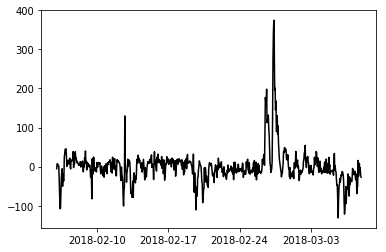

In [25]:
plt.plot(deq['ga:users'], color='k')

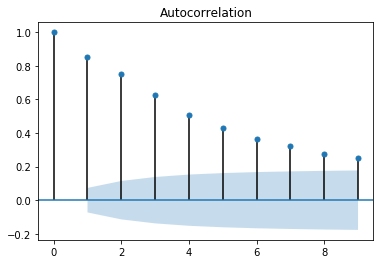

In [26]:
plot_acf(deq['ga:users'], lags=range(10));

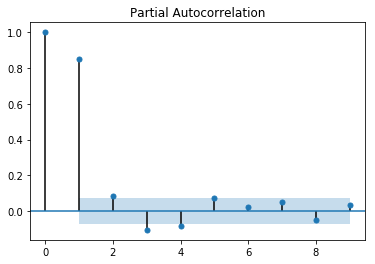

In [27]:
plot_pacf(deq['ga:users'], lags=range(10));

In [28]:
corr_df, lag_df = norm_xcorr_df(deq)

In [29]:
lag_df

,ga:users,ga:newUsers,ga:sessions,ga:bounces,ga:sessionDuration,ga:pageviews,ga:transactions,ga:transactionRevenue
ga:users,0,0,0,0,0,0,-27,-33
ga:newUsers,0,0,0,0,0,0,-25,-32
ga:sessions,0,0,0,0,0,0,-27,-33
ga:bounces,0,0,0,0,0,0,-25,-33
ga:sessionDuration,0,0,0,0,0,0,0,0
ga:pageviews,0,0,0,0,0,0,0,0
ga:transactions,-27,-25,-27,-25,0,0,0,0
ga:transactionRevenue,-33,-32,-33,-33,0,0,0,0


In [30]:
corr_df

,ga:users,ga:newUsers,ga:sessions,ga:bounces,ga:sessionDuration,ga:pageviews,ga:transactions,ga:transactionRevenue
ga:users,1,0.939694,0.992397,0.827801,0.796324,0.911528,0.167264,0.133306
ga:newUsers,0.939694,1,0.941446,0.857522,0.731773,0.859222,0.163279,0.130058
ga:sessions,0.992397,0.941446,1,0.831673,0.803011,0.911193,0.161646,0.132201
ga:bounces,0.827801,0.857522,0.831673,1,0.545915,0.668184,0.154353,0.127319
ga:sessionDuration,0.796324,0.731773,0.803011,0.545915,1,0.845294,0.196545,0.147965
ga:pageviews,0.911528,0.859222,0.911193,0.668184,0.845294,1,0.286552,0.207035
ga:transactions,0.167264,0.163279,0.161646,0.154353,0.196545,0.286552,1,0.707375
ga:transactionRevenue,0.133306,0.130058,0.132201,0.127319,0.147965,0.207035,0.707375,1


In [32]:
data_h.head()

,ga:users,ga:newUsers,ga:sessions,ga:bounces,ga:sessionDuration,ga:pageviews,ga:transactions,ga:transactionRevenue
ga:dateHour,,,,,,,,
2018-02-06 00:00:00,49,33,48,22,9605.0,186,3,7.00
2018-02-06 01:00:00,40,28,37,11,4644.0,228,0,0.00
2018-02-06 02:00:00,30,23,30,12,3157.0,172,0,0.00
2018-02-06 03:00:00,15,14,14,6,1678.0,116,0,0.00
2018-02-06 04:00:00,18,14,18,8,2624.0,91,1,24.87


In [37]:
corr_df_d, lag_df = norm_xcorr_df(deq.resample('D').sum())

In [36]:
corr_df_d

,ga:users,ga:newUsers,ga:sessions,ga:bounces,ga:sessionDuration,ga:pageviews,ga:transactions,ga:transactionRevenue
ga:users,1,0.939694,0.992397,0.827801,0.796324,0.911528,0.167264,0.133306
ga:newUsers,0.939694,1,0.941446,0.857522,0.731773,0.859222,0.163279,0.130058
ga:sessions,0.992397,0.941446,1,0.831673,0.803011,0.911193,0.161646,0.132201
ga:bounces,0.827801,0.857522,0.831673,1,0.545915,0.668184,0.154353,0.127319
ga:sessionDuration,0.796324,0.731773,0.803011,0.545915,1,0.845294,0.196545,0.147965
ga:pageviews,0.911528,0.859222,0.911193,0.668184,0.845294,1,0.286552,0.207035
ga:transactions,0.167264,0.163279,0.161646,0.154353,0.196545,0.286552,1,0.707375
ga:transactionRevenue,0.133306,0.130058,0.132201,0.127319,0.147965,0.207035,0.707375,1


In [38]:
lag_df

,ga:users,ga:newUsers,ga:sessions,ga:bounces,ga:sessionDuration,ga:pageviews,ga:transactions,ga:transactionRevenue
ga:users,0,0,0,0,0,0,-1,21
ga:newUsers,0,0,0,0,0,0,-1,-1
ga:sessions,0,0,0,0,0,0,-1,21
ga:bounces,0,0,0,0,0,0,-1,-1
ga:sessionDuration,0,0,0,0,0,0,0,-1
ga:pageviews,0,0,0,0,0,0,-1,21
ga:transactions,-1,-1,-1,-1,0,-1,0,0
ga:transactionRevenue,21,-1,21,-1,-1,21,0,0


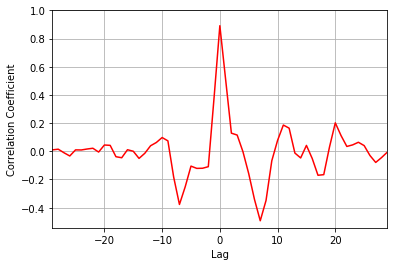

Max correlation is 0.8912 at lag 0


In [40]:
visualize_lag(deq.resample('D').sum()['ga:users'], deq.resample('D').sum()['ga:bounces'])

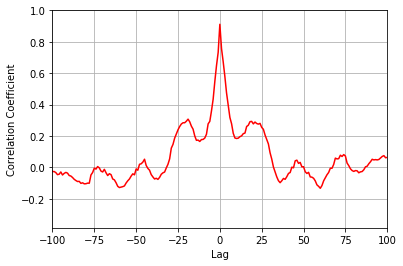

Max correlation is 0.9112 at lag 0


In [41]:
visualize_lag(deq['ga:pageviews'], deq['ga:sessions'], resample='H')

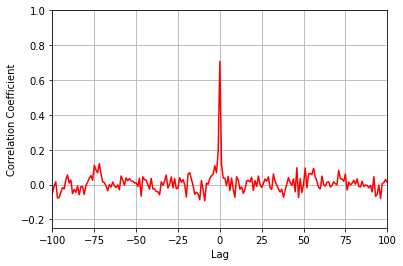

Max correlation is 0.7074 at lag 0


In [42]:
visualize_lag(deq['ga:transactionRevenue'], deq['ga:transactions'], resample='H')

## Analysis other client, anomalous sessionDuration
Possibly scraper bot, great use case for anomaly detection. Has gone undetected for at least a month.

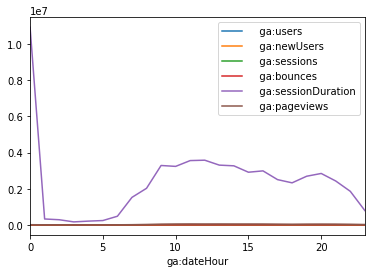

In [42]:
data.groupby(data.index.hour).sum().plot()

In [51]:
sdec = seasonal_decomp(data, freq=24*7)

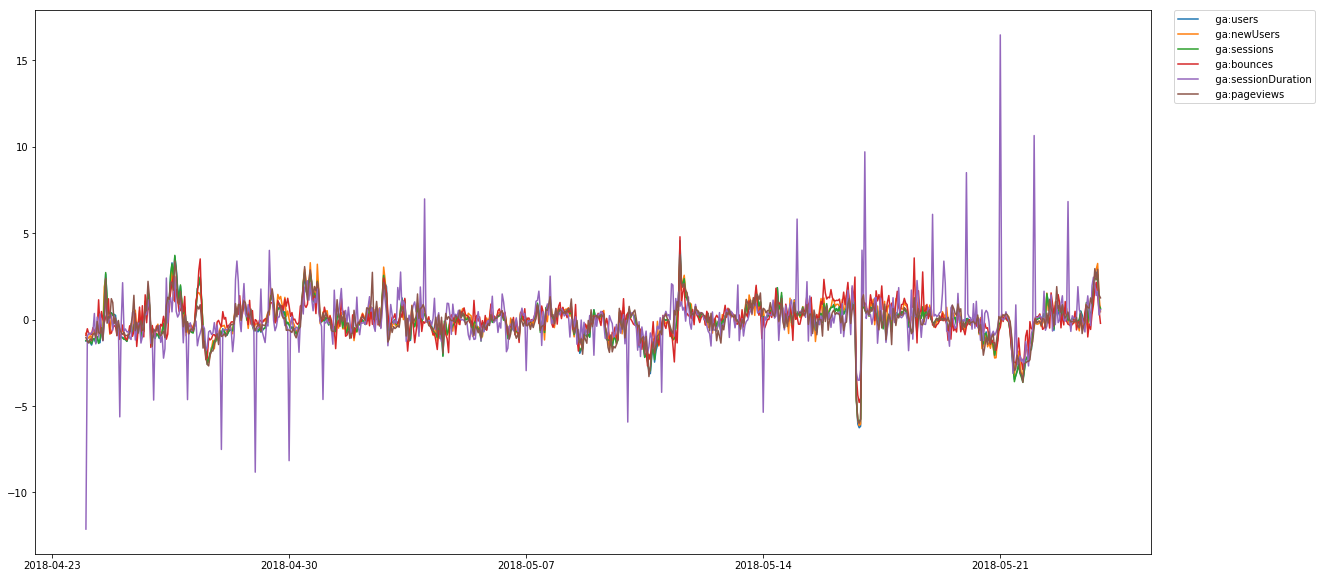

In [52]:
plot_columns(sdec, resample='H', scaled=True)

Clearly lots of structure still left for the Autoencoder to learn. Also the peaks seem to have a strong impact on the seasonal estimation at beginning and end, because they are not constant over time.

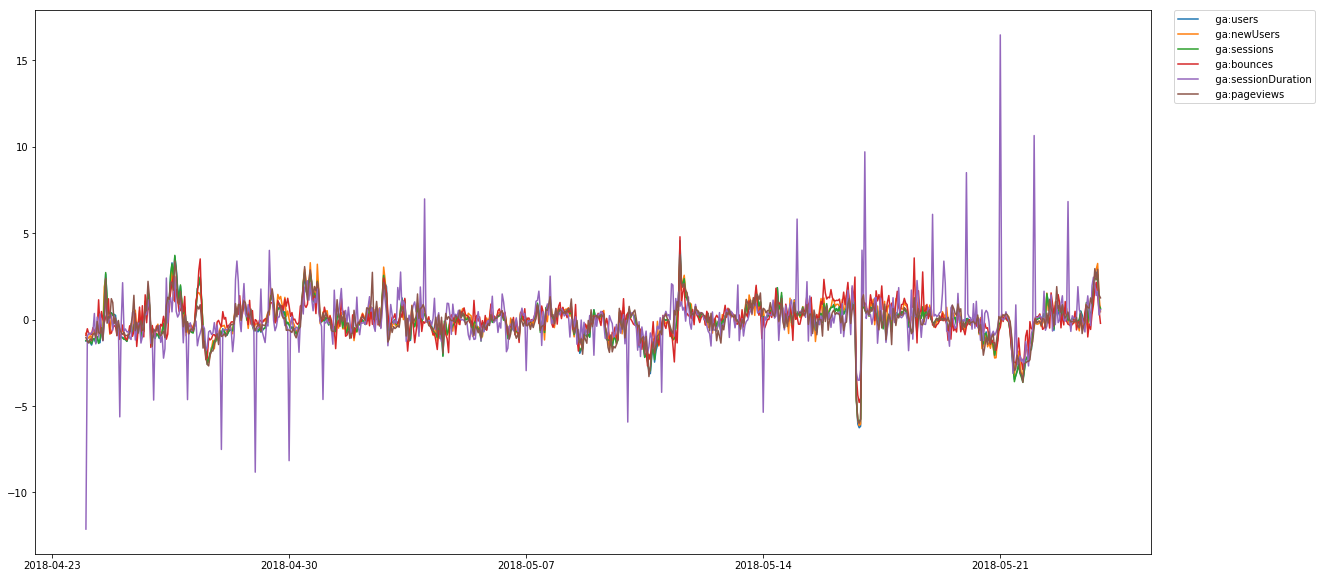

In [53]:
plot_columns(sdec, resample='H', scaled=True)

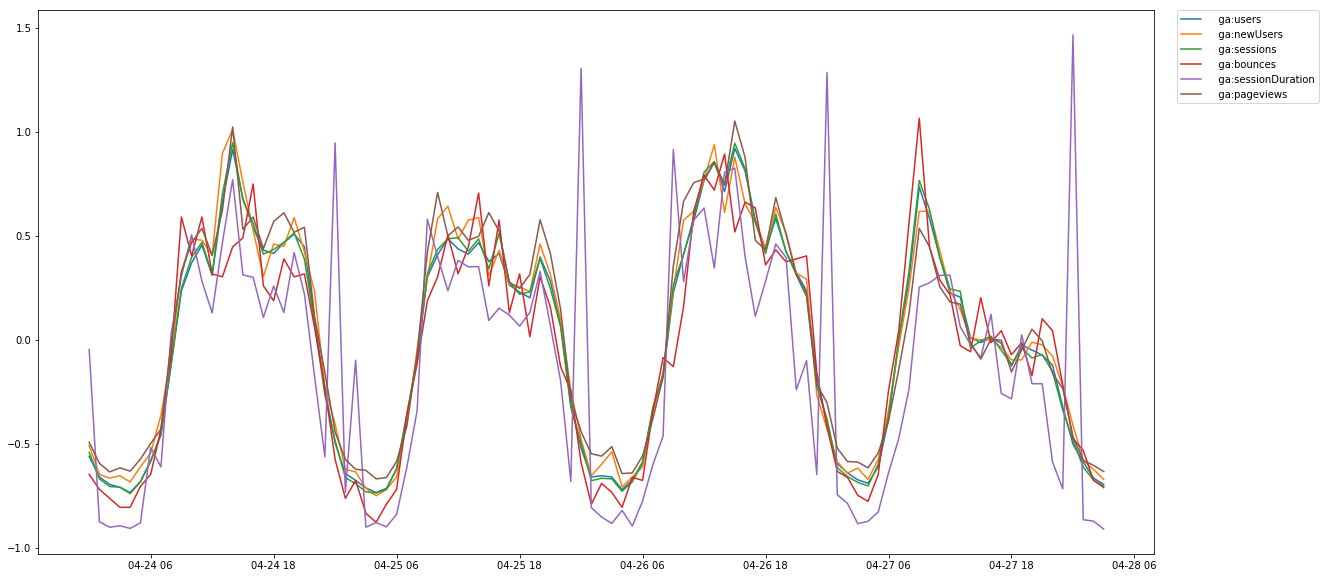

In [54]:
plot_columns(data[0:100], resample='H', scaled=True)

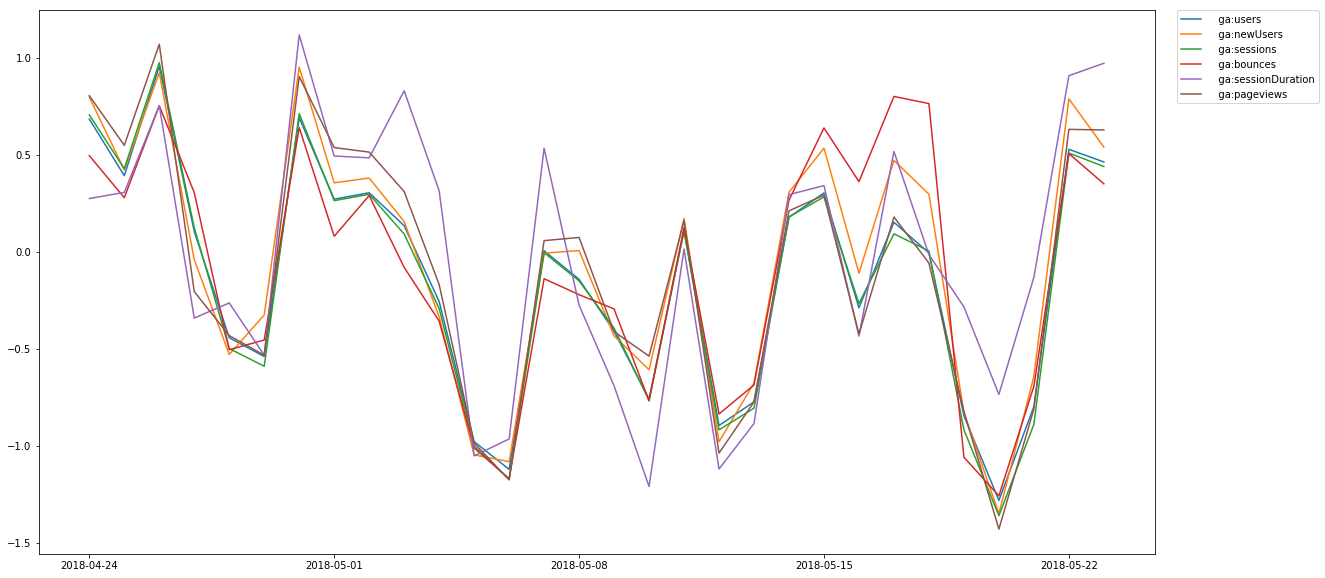

In [56]:
plot_columns(data, resample='D', scaled=True)

## Artificial dataset generation

In [9]:
from artificial_data import create_data, add_nonneg
datatest, anoms, Y, A = create_data(len1=56, len2=8, AM=2.57, mean=0.1, std=0.2, stdcut=1.645, anom_pct=0.01, n_vars=6)

In [9]:
datatest.to_csv('MV_fake-autocorr-test.csv')

In [10]:
anoms.to_csv('MV_fake-autocorr-anoms-test.csv')

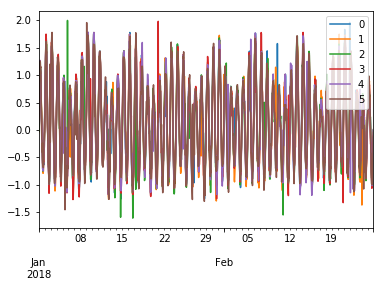

In [4]:
datatest.plot()